# Automatic Data Sanitizer

### Import dependencies

In [1]:
import os
import re
import ast
import math
import yaml
import time
import random
import numbers
import warnings
import threading
import traceback
import pandas as pd
from tqdm import tqdm
from faker import Faker
import concurrent.futures
from sqlalchemy import create_engine, event

In [2]:
from src.stop_execution import StopExecution

### Load environment

In [3]:
pd.set_option('mode.chained_assignment', None)

In [4]:
if not os.path.isfile("env.yml"):
    print("env.yml file not found. env.yml can be created from env.example.yml. Make sure to update variables.")
    raise StopExecution

In [5]:
with open('env.yml') as f:
    env = yaml.safe_load(f)

In [6]:
source_connection_string = env['database']['source_connection']
analysis_sample_size = 1000
chunk_size = 30000
connection_count = 10
temporary_table_suffix = "_scrubbed_empty"

### Database connections

In [7]:
def get_new_connection():
    source_engine = create_engine(
        source_connection_string, 
        pool_recycle=1800,
        connect_args={'ssl_mode':'DISABLED'}
    ) 
    source_connection = source_engine.connect()
    return source_connection

In [8]:
connection_pool = {get_new_connection(): False for i in range(connection_count)}

In [9]:
def get_any_connection():
    return list(connection_pool.keys())[random.randint(0, len(connection_pool)-1)]

In [10]:
def wait_for_connection_release(connection):
    while connection_pool[connection]:
        time.sleep(1)

In [11]:
def connection_release(connection):
    connection_pool[connection] = False

In [12]:
def release_all_connections():
    for connection in list(connection_pool.keys()):
        connection_pool[connection] = False

In [13]:
source_connection = get_new_connection()

### Loading sanitazation configurations

In [14]:
def clean_string(df):
    for col in df.columns:
        df[col] = df[col].str.strip()
    return df

In [15]:
tables_config = clean_string(pd.read_csv(os.path.join('config', 'tables.csv')))
columns_config = clean_string(pd.read_csv(os.path.join('config', 'columns.csv')))

In [16]:
tables_config

,TABLE_SCHEMA,TABLE_NAME,ACTION
0,geosearch,trending_causes_bk,drop


In [17]:
columns_config

,TABLE_SCHEMA,TABLE_NAME,COLUMN_NAME,ACTION
0,givelify,donee_merchant_data,fld_key,scrub
1,givelify,donee_merchant_data,fld_api,scrub
2,givelify,donee_merchant_data,fld_id,scrub
3,givelify,donee_merchant_data,fld_name,scrub
4,givelify,donee_merchant_data,fld_csi,scrub
...,...,...,...,...
115,donee-portal,users,email,scrub
116,donee-portal,users,password,scrub
117,url_shortener,log,ip_address,scrub
118,url_shortener,url,ip,scrub


### Check access

#### Check access for databases

In [18]:
available_databases = set(pd.read_sql_query('SHOW DATABASES', source_connection)['Database'].tolist())

In [19]:
required_databases = set(columns_config['TABLE_SCHEMA'].tolist() + tables_config['TABLE_SCHEMA'].tolist())

In [20]:
not_found_databases = required_databases - available_databases

In [21]:
if not_found_databases:
    print("following databases are not accessible:")
    print(list(not_found_databases))
#     raise StopExecution

following databases are not accessible:
['giving_home', 'geosearch']


In [22]:
columns_config = columns_config[~columns_config['TABLE_SCHEMA'].isin(not_found_databases)]
tables_config = tables_config[~tables_config['TABLE_SCHEMA'].isin(not_found_databases)]

### Analyze Data

In [23]:
def is_unqiue(column):
    return len(column.unique()) == len(column)

In [24]:
_table_lengths = {}
def get_table_length(database, table, connection):
    if (database, table) not in _table_lengths:
        query = "select count(*) as `length` from `%s`.`%s`" % (database, table)
        _table_lengths[(database, table)] = int(pd.read_sql_query(query, connection)['length'][0])
    return _table_lengths[(database, table)]

In [25]:
_min_values = {}
def get_min_value(database, table, column, chunk_size, connection):
    if (database, table, column) not in _min_values:
        iterations = math.ceil(_table_lengths[(database, table)] / chunk_size)
        for i in tqdm(range(iterations), position=0, leave=True):
            query = "select min(`%s`) as `length` from `%s`.`%s` limit %s offset %s" % (
                column, 
                database, 
                table, 
                chunk_size, 
                chunk_size*i
            )
            tmp = pd.read_sql_query(query, connection)['length']
            if len(tmp):
                tmp = tmp[0]
                if (database, table, column) not in _min_values:
                    _min_values[(database, table, column)] = tmp
                else:
                    _min_values[(database, table, column)] = min(_min_values[(database, table, column)], tmp)
    return _min_values[(database, table, column)]

In [26]:
_max_values = {}
def get_max_value(database, table, column, chunk_size, connection):
    if (database, table, column) not in _max_values:
        iterations = math.ceil(_table_lengths[(database, table)] / chunk_size)
        for i in tqdm(range(iterations), position=0, leave=True):
            query = "select max(`%s`) as `length` from `%s`.`%s` limit %s offset %s" % (
                column, 
                database, 
                table, 
                chunk_size, 
                chunk_size*i
            )
            tmp = pd.read_sql_query(query, connection)['length']
            if len(tmp):
                tmp = tmp[0]
                if (database, table, column) not in _max_values:
                    _max_values[(database, table, column)] = tmp
                else:
                    _max_values[(database, table, column)] = max(_max_values[(database, table, column)], tmp)
    return _max_values[(database, table, column)]

In [27]:
def analyze_column(index, row, limit, connection):
    wait_for_connection_release(connection)
    connection_pool[connection] = True
    try:
        query = "select `%s` from `%s`.`%s` limit %s" % (row['COLUMN_NAME'], row['TABLE_SCHEMA'], row['TABLE_NAME'], str(limit))
        column = pd.read_sql_query(query, connection)[row['COLUMN_NAME']]
        columns_config.at[index, 'is_unique'] = is_unqiue(column)
        columns_config.at[index, 'length'] = get_table_length(
            row['TABLE_SCHEMA'], 
            row['TABLE_NAME'],
            connection
        )
        if len(column) and column[0] != None and not isinstance(column[0], str):
            columns_config.at[index, 'min'] = get_min_value(
                row['TABLE_SCHEMA'], 
                row['TABLE_NAME'], 
                row['COLUMN_NAME'],
                analysis_sample_size,
                connection
            )
            columns_config.at[index, 'max'] = get_max_value(
                row['TABLE_SCHEMA'], 
                row['TABLE_NAME'], 
                row['COLUMN_NAME'],
                analysis_sample_size,
                connection
            )
    except Exception as e:
        print(e)
        traceback.print_exc()
    finally:
        connection_release(connection)

In [28]:
columns_config['min'] = None
columns_config['min'] = None
columns_config['length'] = None
columns_config['is_unique'] = None

In [29]:
futures = []
args = []
for index, row in tqdm(columns_config.iterrows(), total=len(columns_config), position=0, leave=True):
    connection = get_any_connection()
    args.append((
        index, 
        row.copy(), 
        analysis_sample_size, 
        connection
    ))
executor=concurrent.futures.ThreadPoolExecutor(max_workers=connection_count)
for arg in args:
    futures.append(executor.submit(analyze_column, *arg))


100%|██████████| 119/119 [00:00<00:00, 9455.58it/s]


In [30]:
total = len(futures)
for future in list(tqdm(concurrent.futures.as_completed(futures), total=total)):
    pass

100%|██████████| 119/119 [00:27<00:00,  4.29it/s]


In [31]:
columns_config

,TABLE_SCHEMA,TABLE_NAME,COLUMN_NAME,ACTION,min,length,is_unique,max
0,givelify,donee_merchant_data,fld_key,scrub,1,4120,True,4121.0
1,givelify,donee_merchant_data,fld_api,scrub,None,4120,False,NaN
2,givelify,donee_merchant_data,fld_id,scrub,None,4120,True,NaN
3,givelify,donee_merchant_data,fld_name,scrub,None,4120,False,NaN
4,givelify,donee_merchant_data,fld_csi,scrub,None,4120,False,NaN
...,...,...,...,...,...,...,...,...
114,donee-portal,signup_progress,updated_at,scrub,2020-11-03 21:17:54,7674,False,2021-03-02 00:04:54
115,donee-portal,users,email,scrub,None,0,True,NaN
116,donee-portal,users,password,scrub,None,0,True,NaN
117,url_shortener,log,ip_address,scrub,None,383753,False,NaN


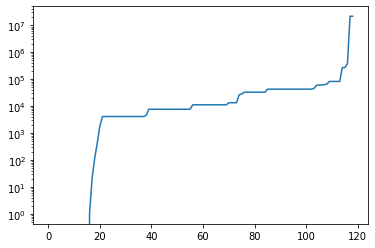

In [32]:
if len(columns_config):
    columns_config['length'].sort_values(ignore_index=True).plot(logy=True)

In [33]:
def analyze_tables(index, row):
    tables_config.loc[index, 'length'] = get_table_length(row['TABLE_SCHEMA'], row['TABLE_NAME'])

In [34]:
for index, row in tqdm(tables_config.iterrows(), total=len(tables_config)):
    analyze_tables(index, row, analysis_sample_size)

0it [00:00, ?it/s]


In [35]:
if len(tables_config):
    tables_config['length'].sort_values(ignore_index=True).plot(logy=True)

### Clone to temporary tables

In [36]:
unique_tables_for_columns = columns_config.drop_duplicates(
    ['TABLE_SCHEMA', 'TABLE_NAME']
)[['TABLE_SCHEMA', 'TABLE_NAME', 'length']]
unique_tables_for_tables = tables_config.drop_duplicates(    
    ['TABLE_SCHEMA', 'TABLE_NAME']
)[['TABLE_SCHEMA', 'TABLE_NAME']]
unique_tables = pd.concat(
    [unique_tables_for_columns, unique_tables_for_tables],
    axis=0,
    ignore_index=True
)
unique_tables

,TABLE_SCHEMA,TABLE_NAME,length
0,givelify,donee_merchant_data,4120
1,givelify,donee_merchant_data_express,32947
2,givelify_payments,deleted_submerchant_log,1838
3,givelify_payments,submerchant_log,13382
4,givelify_payments,underwriting_status,26484
5,payment_instruments,failed_jobs,0
6,payment_instruments,password_resets,0
7,payment_instruments,payment_instruments,11212
8,payment_instruments,users,0
9,salesforce_checks,contact_issues,116


In [37]:
def clone_table(database, table, length, suffix, chunk_size):
    new_table = "%s%s" % (table, suffix)
    try:
        query = "DROP TABLE IF EXISTS `%s`.`%s`" % (
            database, new_table
        )
        source_connection.execute(query)
    except Exception as e:
        print(e)
    query = "CREATE TABLE `%s`.`%s` LIKE `%s`.`%s`" % (
        database, new_table, database, table
    )
    source_connection.execute(query)
    
    query = "SET unique_checks=0; SET foreign_key_checks=0; "
    source_connection.execute(query)
    
    query = "ALTER TABLE `%s`.`%s` ENABLE KEYS;" % (
        database, new_table
    )
    query = "SET unique_checks=1; SET foreign_key_checks=1;"
    source_connection.execute(query)

In [38]:
for index, row in tqdm(unique_tables.iterrows(), total=len(unique_tables)):
    clone_table(
        row['TABLE_SCHEMA'], 
        row['TABLE_NAME'], 
        row['length'], 
        temporary_table_suffix,
        chunk_size
    )

100%|██████████| 29/29 [00:09<00:00,  2.98it/s]


### Scrubing

In [39]:
fake = Faker()

In [40]:
fake.address()

'0564 Lacey Trace Suite 800\nSmithville, NH 41117'

In [41]:
custom_sanitization_function={
    #'<db_name>.<table_name>.<column_name>': function reference
    'givelify.donee_merchant_data.fld_address1': fake.address,
    'givelify.donee_merchant_data.fld_address2': fake.address,
    'payment_instruments.payment_instruments.address1': fake.address,
    'payment_instruments.payment_instruments.address2': fake.address,
    'salesforce_checks.donations.ip_address': fake.address,
    'salesforce_checks.donee_bank_info.billing_address': fake.address,
    'donee-portal.new_donors.full_address': fake.address,
    'donee-portal.signup_progress.address': fake.address,
}

In [42]:
hash_seed = 0
def numeric_hash(num):
    global hash_seed
    hash_seed+=1
    return hash(str(num)+str(hash_seed+1))

In [43]:
def numeric_hash_range(num, min_value, max_value):
    if min_value is None:
        min_value = 0
    if max_value is None:
        max_value = int(num)
    deno = max_value-min_value
    if deno == 0:
        deno = 1
    return min_value + (numeric_hash(num) % (deno))

In [44]:
def sanitize_numeric(cell_value, table_name, column_name, min_value, max_value, is_unique, unique_list):
    collision_probability = 0.1
    cell_value = numeric_hash_range(cell_value, min_value, max_value)
    index = 0
    if min_value is None:
        min_value = 0
    if max_value is None:
        max_value = int(cell_value)

    
    while is_unique and cell_value in unique_list:
        max_multiple = 1/collision_probability
        cell_value = numeric_hash_range(str(cell_value)+"1", min_value, max_value*max_multiple) + index
        index+=1
    unique_list.add(cell_value)
    return cell_value

In [45]:
def character_hash_upper(char):
    return chr(numeric_hash_range(ord(char), 65, 90))

In [46]:
def character_hash_lower(char):
    return chr(numeric_hash_range(ord(char), 97, 122))

In [47]:
def in_custom_sanitization_function(table_name, column_name):
    return F"{table_name}.{column_name}" in custom_sanitization_function

In [48]:
def sanitize_string_raw(cell_value, is_unique, unique_list):
    chs = []
    for ch in cell_value:
        if ch == " ":
            chs.append(ch)
        elif re.match(r"^[^a-zA-Z0-9]+$", ch):
            chs.append(ch)
        elif re.match(r"^[0-9]+$", ch):
            chs.append(str(numeric_hash_range(ch,0,9)))
        elif re.match(r"^[A-Z]+$", ch):
            x = "AEIOU"
            if ch in x:
                chs.append(x[numeric_hash_range(ch, 0, 4)])
            else:
                chs.append(character_hash_upper(ch))
        elif re.match(r"^[a-z]+$", ch):
            x = "aeiou"
            if ch in x:
                chs.append(x[numeric_hash_range(ch, 0, 4)])
            else:
                chs.append(character_hash_lower(ch))
        else:
            chs.append(character_hash(ch))
    cell_value = "".join(chs)
    while is_unique and cell_value in unique_list:
        cell_value+=cell_value[len(cell_value) - 1]
    unique_list.add(cell_value)
    return cell_value

In [49]:
def sanitize_string(cell_value, table_name, column_name, min_value, max_value, is_unique, unique_list):
    if in_custom_sanitization_function(table_name, column_name):
        return custom_sanitization_function[F"{table_name}.{column_name}"](
            cell_value, 
            min_value, 
            max_value, 
            is_unique, 
            unique_list
        )
    return sanitize_string_raw(cell_value, is_unique, unique_list)    

In [50]:
def is_numeric(value):
    return value is not None and (isinstance(value, numbers.Number) or str(value).isnumeric())

def is_string(value):
    return value is not None and isinstance(value, str)

In [51]:
sanitize_map = {}

In [52]:
def sanitize_cell(cell_value, table_name, column_name, min_value, max_value, is_unique, unique_list):
    if cell_value in sanitize_map:
        return sanitize_map[cell_value]
    new_cell_value = cell_value
    if cell_value is None:
        return cell_value
    elif is_numeric(cell_value):
        new_cell_value = sanitize_numeric(cell_value, table_name, column_name, min_value, max_value, is_unique, unique_list)
    elif is_string(cell_value):
        new_cell_value = sanitize_string(cell_value, table_name, column_name, min_value, max_value, is_unique, unique_list)
    sanitize_map[cell_value] = new_cell_value
    return new_cell_value

In [53]:
def clean_number(num):
    str_num = str(num)
    if str_num == "0" or str_num == "0.0":
        return ast.literal_eval(str_num)
    else:
        return ast.literal_eval(str_num.strip("0"))

In [54]:
def get_query(table, database_name, table_name, temporary_table_suffix):
    query = """INSERT IGNORE INTO `%s`.`%s%s` VALUES """ % (database_name, table_name, temporary_table_suffix)
    fmt_values = []
    values = []
    count = 0
    
    for index, r in table.iterrows():
        count += len(r)
        fmt_values.append(",".join(["%s" for v in r]))
        for v in r:
            if str(v).lower() == "nan":
                v = None
            values.append(v)
    
    query = query+" ("+("),(".join(fmt_values)) +")"

    return query, values

In [55]:
for connection in tqdm(list(connection_pool.keys())):
    connection.execute('SET unique_checks=0; SET FOREIGN_KEY_CHECKS=0;')

100%|██████████| 10/10 [00:00<00:00, 20.69it/s]


In [56]:
def sanitize_table_chunk(
    database, table_name, columns, 
    chunk_size, row_count, temporary_table_suffix,
    unique_list, iteration, connection
):
    wait_for_connection_release(connection)
    connection_pool[connection] = True
    try:
        count = iteration * chunk_size
        if chunk_size > row_count:
            chunk_size = row_count
        query = "SELECT * FROM `%s`.`%s` LIMIT %s OFFSET %s;" % (
            database, 
            table_name, 
            str(chunk_size), 
            str(count)
        )
        table = pd.read_sql_query(query, connection)
        for column_name in table.columns:
            if column_name not in columns['COLUMN_NAME'].tolist():
                continue
            if column_name not in unique_list:
                unique_list[column_name] = set()
            column = table[column_name]
            min_value = None
            max_value = None
            try:
                min_value = clean_number(column.fillna(0).min())
                max_value = clean_number(column.fillna(0).max())
            except Exception as e:
                pass
            if min_value is None:
                try:
                    min_value = clean_number(column.fillna('0').min())
                    max_value = clean_number(column.fillna('0').max())
                except Exception as e:
                    pass
            is_unique = columns[columns['COLUMN_NAME'] == column_name]['is_unique'].tolist()[0]
            table[column_name] = column.apply(
                sanitize_cell,
                args=
                (
                    table_name, 
                    column_name,
                    min_value,
                    max_value,
                    is_unique,
                    unique_list[column_name]
                )
            )
        query, inputs = get_query(table, database, table_name, temporary_table_suffix)
        connection.execute(query, inputs)
    except Exception as e:
        print(e)
        traceback.print_exc()
    finally:
        connection_release(connection)

In [57]:
def sanitize_table(
    database, table_name, columns, 
    chunk_size, row_count, temporary_table_suffix
):
    iterations = int(math.ceil(row_count / chunk_size))
    unique_list = {}
    args = []
    for iteration in tqdm(range(iterations), position=0, leave=True):
        connection = get_any_connection()
        args.append((
            database, table_name, columns.copy(), 
            chunk_size, row_count, temporary_table_suffix,
            unique_list, iteration, connection
        ))
    futures = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=connection_count) as executor:
        for arg in args:
            futures.append(executor.submit(sanitize_table_chunk, *arg))
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), position=0, leave=True):
            try:
                future.result()
            except BaseException as e:
                print(e)
                traceback.print_exc()

In [58]:
release_all_connections()
for index, row in tqdm(unique_tables.iterrows(), total=len(unique_tables), position=0, leave=True):
    columns = columns_config[(columns_config['TABLE_SCHEMA'] == row['TABLE_SCHEMA']) & (columns_config['TABLE_NAME'] == row['TABLE_NAME'])]
    sanitize_table(
        row['TABLE_SCHEMA'], 
        row['TABLE_NAME'], 
        columns, 
        chunk_size, 
        row['length'],
        temporary_table_suffix
    )

100%|██████████| 1/1 [00:15<00:00, 15.45s/it]
0it [00:00, ?it/s]/29 [02:53<11:49, 29.57s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:05<00:00,  5.11s/it]
0it [00:00, ?it/s]/29 [02:58<04:25, 12.65s/it]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:08<00:00,  2.77s/it]
0it [00:00, ?it/s]8/29 [2:21:57<43:13, 235.75s/it]  
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  5.53it/s]
0it [00:00, ?it/s]0/29 [2:21:58<19:21, 129.10s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [01:04<00:00, 64.01s/it]
0it [00:00, ?it/s]6/29 [2:24:07<02:25, 48.46s/it]
0it [00:00, ?it/s]
100%|██████████| 29/29 [2:25:19<00:00, 300.68s/it]


In [59]:
tables = columns_config.drop_duplicates(['TABLE_SCHEMA', 'TABLE_NAME'])
tables

,TABLE_SCHEMA,TABLE_NAME,COLUMN_NAME,ACTION,min,length,is_unique,max
0,givelify,donee_merchant_data,fld_key,scrub,1,4120,True,4121.0
17,givelify,donee_merchant_data_express,id,scrub,1,32947,True,33045
26,givelify_payments,deleted_submerchant_log,response,scrub,None,1838,True,NaN
27,givelify_payments,submerchant_log,acceptor_id,scrub,None,13382,True,NaN
31,givelify_payments,underwriting_status,response,scrub,None,26484,True,NaN
32,payment_instruments,failed_jobs,payload,scrub,None,0,True,NaN
34,payment_instruments,password_resets,email,scrub,None,0,True,NaN
36,payment_instruments,payment_instruments,masked,scrub,None,11212,False,NaN
50,payment_instruments,users,name,scrub,None,0,True,NaN
54,salesforce_checks,contact_issues,email,scrub,None,116,True,NaN


In [60]:
pd.read_sql_query('SELECT * FROM `givelify`.`donee_merchant_data` LIMIT 100', source_connection)

,fld_key,fld_api,fld_id,fld_name,fld_csi,fld_csp,fld_sic,fld_address1,fld_address2,fld_city,fld_state,fld_zip,fld_country,fld_donee_id,fld_added,fld_profile_id,fld_config
0,1,None,4445016736421,Anointed City of the Lord,,,,,,Indianapolis,IN,46205,USA,90,2016-10-03 20:31:00,DONEE0000000090_DEDC61300C,taLn2pqQ69ja1tjd4q+RnaheiYnb08/YyuLR1qpQ2ejilZ...
1,2,None,4445016816553,None,None,None,None,None,None,None,None,None,None,75,2016-10-03 20:31:05,DONEE0000000075_DEDC61300C,taLn2pqQ69ja1tjd4q+RnaheiYnb08/YyuLR1qpQ2ejilZ...
2,3,None,4445016816645,None,None,None,None,None,None,None,None,None,None,172,2016-10-03 20:31:10,DONEE0000000172_DEDC61300C,taLn2pqQ69ja1tjd4q+RnaheiYnb08/YyuLR1qpQ2ejilZ...
3,4,None,4445016816660,None,None,None,None,None,None,None,None,None,None,19,2016-10-03 20:31:16,DONEE0000000019_DEDC61300C,taLn2pqQ69ja1tjd4q+RnaheiYnb08/YyuLR1qpQ2ejilZ...
4,5,None,4445016816678,None,None,None,None,None,None,None,None,None,None,22,2016-10-03 20:31:20,DONEE0000000022_DEDC61300C,taLn2pqQ69ja1tjd4q+RnaheiYnb08/YyuLR1qpQ2ejilZ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,None,4445016852699,None,None,None,None,None,None,None,None,None,None,404,2016-10-03 20:38:56,DONEE0000000404_DEDC61300C,taLn2pqQ69ja1tjd4q+RnaheiYnb08/YyuLR1qpQ2ejilZ...
96,97,None,4445016852707,None,None,None,None,None,None,None,None,None,None,458,2016-10-03 20:39:01,DONEE0000000458_DEDC61300C,taLn2pqQ69ja1tjd4q+RnaheiYnb08/YyuLR1qpQ2ejilZ...
97,98,None,4445016852715,None,None,None,None,None,None,None,None,None,None,490,2016-10-03 20:39:06,DONEE0000000490_DEDC61300C,taLn2pqQ69ja1tjd4q+RnaheiYnb08/YyuLR1qpQ2ejilZ...
98,99,None,4445016853440,None,None,None,None,None,None,None,None,None,None,519,2016-10-03 20:39:11,DONEE0000000519_DEDC61300C,taLn2pqQ69ja1tjd4q+RnaheiYnb08/YyuLR1qpQ2ejilZ...


In [61]:
for index, row in tqdm(tables.iterrows(), total=len(tables)):
    
    query = "SET unique_checks=0; SET foreign_key_checks=0;"
    print(query)
    source_connection.execute(query)
    source_connection.execute('START TRANSACTION;');
    query = "TRUNCATE `%s`.`%s`;" % (
        row['TABLE_SCHEMA'], 
        row['TABLE_NAME']
    )
    print(query)
    source_connection.execute(query)
    
    query = "INSERT INTO `%s`.`%s` (SELECT * FROM `%s`.`%s%s`);" % (
        row['TABLE_SCHEMA'], 
        row['TABLE_NAME'], 
        row['TABLE_SCHEMA'], 
        row['TABLE_NAME'], 
        temporary_table_suffix
    )
    print(query)
    source_connection.execute(query)
    
    query = "DROP TABLE `%s`.`%s%s`;" % (
        row['TABLE_SCHEMA'], 
        row['TABLE_NAME'],
         temporary_table_suffix
    )
    print(query)
    source_connection.execute(query)
    source_connection.execute('COMMIT;')
    
    query = "SET unique_checks=1; SET foreign_key_checks=1;"
    print(query)
    source_connection.execute(query)

  0%|          | 0/29 [00:00<?, ?it/s]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `givelify`.`donee_merchant_data`;
INSERT INTO `givelify`.`donee_merchant_data` (SELECT * FROM `givelify`.`donee_merchant_data_scrubbed_empty`);
DROP TABLE `givelify`.`donee_merchant_data_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


  3%|▎         | 1/29 [00:02<00:58,  2.09s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `givelify`.`donee_merchant_data_express`;
INSERT INTO `givelify`.`donee_merchant_data_express` (SELECT * FROM `givelify`.`donee_merchant_data_express_scrubbed_empty`);
DROP TABLE `givelify`.`donee_merchant_data_express_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


  7%|▋         | 2/29 [00:03<00:52,  1.94s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `givelify_payments`.`deleted_submerchant_log`;
INSERT INTO `givelify_payments`.`deleted_submerchant_log` (SELECT * FROM `givelify_payments`.`deleted_submerchant_log_scrubbed_empty`);
DROP TABLE `givelify_payments`.`deleted_submerchant_log_scrubbed_empty`;


 10%|█         | 3/29 [00:04<00:36,  1.41s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `givelify_payments`.`submerchant_log`;
INSERT INTO `givelify_payments`.`submerchant_log` (SELECT * FROM `givelify_payments`.`submerchant_log_scrubbed_empty`);
DROP TABLE `givelify_payments`.`submerchant_log_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 14%|█▍        | 4/29 [00:06<00:38,  1.55s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `givelify_payments`.`underwriting_status`;
INSERT INTO `givelify_payments`.`underwriting_status` (SELECT * FROM `givelify_payments`.`underwriting_status_scrubbed_empty`);
DROP TABLE `givelify_payments`.`underwriting_status_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 17%|█▋        | 5/29 [00:08<00:38,  1.58s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `payment_instruments`.`failed_jobs`;
INSERT INTO `payment_instruments`.`failed_jobs` (SELECT * FROM `payment_instruments`.`failed_jobs_scrubbed_empty`);
DROP TABLE `payment_instruments`.`failed_jobs_scrubbed_empty`;


 21%|██        | 6/29 [00:08<00:29,  1.28s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `payment_instruments`.`password_resets`;
INSERT INTO `payment_instruments`.`password_resets` (SELECT * FROM `payment_instruments`.`password_resets_scrubbed_empty`);
DROP TABLE `payment_instruments`.`password_resets_scrubbed_empty`;


 24%|██▍       | 7/29 [00:09<00:23,  1.09s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `payment_instruments`.`payment_instruments`;
INSERT INTO `payment_instruments`.`payment_instruments` (SELECT * FROM `payment_instruments`.`payment_instruments_scrubbed_empty`);
DROP TABLE `payment_instruments`.`payment_instruments_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 28%|██▊       | 8/29 [00:10<00:22,  1.08s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `payment_instruments`.`users`;
INSERT INTO `payment_instruments`.`users` (SELECT * FROM `payment_instruments`.`users_scrubbed_empty`);
DROP TABLE `payment_instruments`.`users_scrubbed_empty`;


 31%|███       | 9/29 [00:11<00:19,  1.05it/s]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `salesforce_checks`.`contact_issues`;
INSERT INTO `salesforce_checks`.`contact_issues` (SELECT * FROM `salesforce_checks`.`contact_issues_scrubbed_empty`);
DROP TABLE `salesforce_checks`.`contact_issues_scrubbed_empty`;


 34%|███▍      | 10/29 [00:11<00:16,  1.15it/s]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `salesforce_checks`.`donations`;
INSERT INTO `salesforce_checks`.`donations` (SELECT * FROM `salesforce_checks`.`donations_scrubbed_empty`);
DROP TABLE `salesforce_checks`.`donations_scrubbed_empty`;


 38%|███▊      | 11/29 [45:31<4:09:55, 833.07s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `salesforce_checks`.`donee_bank_info`;
INSERT INTO `salesforce_checks`.`donee_bank_info` (SELECT * FROM `salesforce_checks`.`donee_bank_info_scrubbed_empty`);
DROP TABLE `salesforce_checks`.`donee_bank_info_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 41%|████▏     | 12/29 [45:33<2:44:24, 580.26s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `salesforce_checks`.`donee_campuses`;
INSERT INTO `salesforce_checks`.`donee_campuses` (SELECT * FROM `salesforce_checks`.`donee_campuses_scrubbed_empty`);
DROP TABLE `salesforce_checks`.`donee_campuses_scrubbed_empty`;


 45%|████▍     | 13/29 [45:34<1:47:55, 404.70s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `salesforce_checks`.`donee_info`;
INSERT INTO `salesforce_checks`.`donee_info` (SELECT * FROM `salesforce_checks`.`donee_info_scrubbed_empty`);
DROP TABLE `salesforce_checks`.`donee_info_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 48%|████▊     | 14/29 [45:38<1:10:53, 283.57s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `salesforce_checks`.`donee_official_info`;
INSERT INTO `salesforce_checks`.`donee_official_info` (SELECT * FROM `salesforce_checks`.`donee_official_info_scrubbed_empty`);
DROP TABLE `salesforce_checks`.`donee_official_info_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 52%|█████▏    | 15/29 [45:42<46:31, 199.36s/it]  

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `salesforce_checks`.`givelify_donees`;
INSERT INTO `salesforce_checks`.`givelify_donees` (SELECT * FROM `salesforce_checks`.`givelify_donees_scrubbed_empty`);
DROP TABLE `salesforce_checks`.`givelify_donees_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 55%|█████▌    | 16/29 [45:44<30:19, 139.95s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `salesforce_checks`.`givelify_officials`;
INSERT INTO `salesforce_checks`.`givelify_officials` (SELECT * FROM `salesforce_checks`.`givelify_officials_scrubbed_empty`);
DROP TABLE `salesforce_checks`.`givelify_officials_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 59%|█████▊    | 17/29 [45:46<19:41, 98.48s/it] 

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `salesforce_checks`.`remote_contacts`;
INSERT INTO `salesforce_checks`.`remote_contacts` (SELECT * FROM `salesforce_checks`.`remote_contacts_scrubbed_empty`);
DROP TABLE `salesforce_checks`.`remote_contacts_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 62%|██████▏   | 18/29 [45:48<12:45, 69.60s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `donee-portal`.`donee_report_emails`;
INSERT INTO `donee-portal`.`donee_report_emails` (SELECT * FROM `donee-portal`.`donee_report_emails_scrubbed_empty`);
DROP TABLE `donee-portal`.`donee_report_emails_scrubbed_empty`;


 66%|██████▌   | 19/29 [45:49<08:09, 48.91s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `donee-portal`.`failed_jobs`;
INSERT INTO `donee-portal`.`failed_jobs` (SELECT * FROM `donee-portal`.`failed_jobs_scrubbed_empty`);
DROP TABLE `donee-portal`.`failed_jobs_scrubbed_empty`;


 69%|██████▉   | 20/29 [45:50<05:09, 34.44s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `donee-portal`.`new_donors`;
INSERT INTO `donee-portal`.`new_donors` (SELECT * FROM `donee-portal`.`new_donors_scrubbed_empty`);
DROP TABLE `donee-portal`.`new_donors_scrubbed_empty`;


 72%|███████▏  | 21/29 [45:51<03:14, 24.31s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `donee-portal`.`reconciliation_recipients`;
INSERT INTO `donee-portal`.`reconciliation_recipients` (SELECT * FROM `donee-portal`.`reconciliation_recipients_scrubbed_empty`);
DROP TABLE `donee-portal`.`reconciliation_recipients_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 76%|███████▌  | 22/29 [45:53<02:04, 17.75s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `donee-portal`.`reconciliation_report_logs`;
INSERT INTO `donee-portal`.`reconciliation_report_logs` (SELECT * FROM `donee-portal`.`reconciliation_report_logs_scrubbed_empty`);
DROP TABLE `donee-portal`.`reconciliation_report_logs_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 79%|███████▉  | 23/29 [46:01<01:29, 14.91s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `donee-portal`.`reports`;
INSERT INTO `donee-portal`.`reports` (SELECT * FROM `donee-portal`.`reports_scrubbed_empty`);
DROP TABLE `donee-portal`.`reports_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 83%|████████▎ | 24/29 [46:02<00:53, 10.70s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `donee-portal`.`sessions`;
INSERT INTO `donee-portal`.`sessions` (SELECT * FROM `donee-portal`.`sessions_scrubbed_empty`);
DROP TABLE `donee-portal`.`sessions_scrubbed_empty`;


 86%|████████▌ | 25/29 [46:03<00:30,  7.70s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `donee-portal`.`signup_progress`;
INSERT INTO `donee-portal`.`signup_progress` (SELECT * FROM `donee-portal`.`signup_progress_scrubbed_empty`);
DROP TABLE `donee-portal`.`signup_progress_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 90%|████████▉ | 26/29 [46:04<00:17,  5.67s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `donee-portal`.`users`;
INSERT INTO `donee-portal`.`users` (SELECT * FROM `donee-portal`.`users_scrubbed_empty`);
DROP TABLE `donee-portal`.`users_scrubbed_empty`;


 93%|█████████▎| 27/29 [46:05<00:08,  4.18s/it]

SET unique_checks=1; SET foreign_key_checks=1;
SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `url_shortener`.`log`;
INSERT INTO `url_shortener`.`log` (SELECT * FROM `url_shortener`.`log_scrubbed_empty`);
DROP TABLE `url_shortener`.`log_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


 97%|█████████▋| 28/29 [46:12<00:05,  5.14s/it]

SET unique_checks=0; SET foreign_key_checks=0;
TRUNCATE `url_shortener`.`url`;
INSERT INTO `url_shortener`.`url` (SELECT * FROM `url_shortener`.`url_scrubbed_empty`);
DROP TABLE `url_shortener`.`url_scrubbed_empty`;
SET unique_checks=1; SET foreign_key_checks=1;


100%|██████████| 29/29 [46:14<00:00, 95.67s/it]


In [74]:
pd.read_sql_query('SELECT COUNT(*) FROM `salesforce_checks`.`remote_contacts` LIMIT 100', source_connection)

,COUNT(*)
0,66122


In [63]:
query = "SET unique_checks=1; SET foreign_key_checks=1;"
source_connection.execute(query)

In [64]:

print(source_connection.execute('SELECT 1;'))
